In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

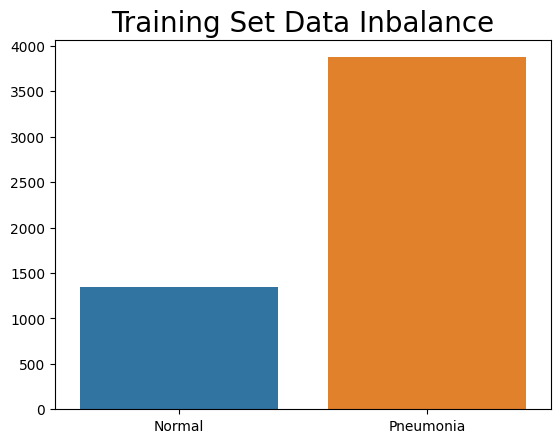

In [2]:
path = 'Chest X-Ray'
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

In [3]:

transformer = {
    'dataset1': transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                           ]),
    
    'dataset2' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=1),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                            transform.ToTensor()
                                    
                                           ]),
    'dataset3' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=0.5),
                                            transform.RandomRotation(15),
                                            transform.RandomGrayscale(p=1),
                                            transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                            transform.ToTensor()
                                           ]),
}

In [4]:
dataset1 = ImageFolder(path+'/train', 
                      transform=transformer['dataset1'])

dataset2 = ImageFolder(path+'/train', 
                      transform=transformer['dataset2'])

dataset3 = ImageFolder(path+'/train', 
                      transform=transformer['dataset3'])

norm1, _ = train_test_split(dataset2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(dataset3, test_size= 4023/(1341+3875), shuffle=False)

dataset = ConcatDataset([dataset1, norm1, norm2])



In [5]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

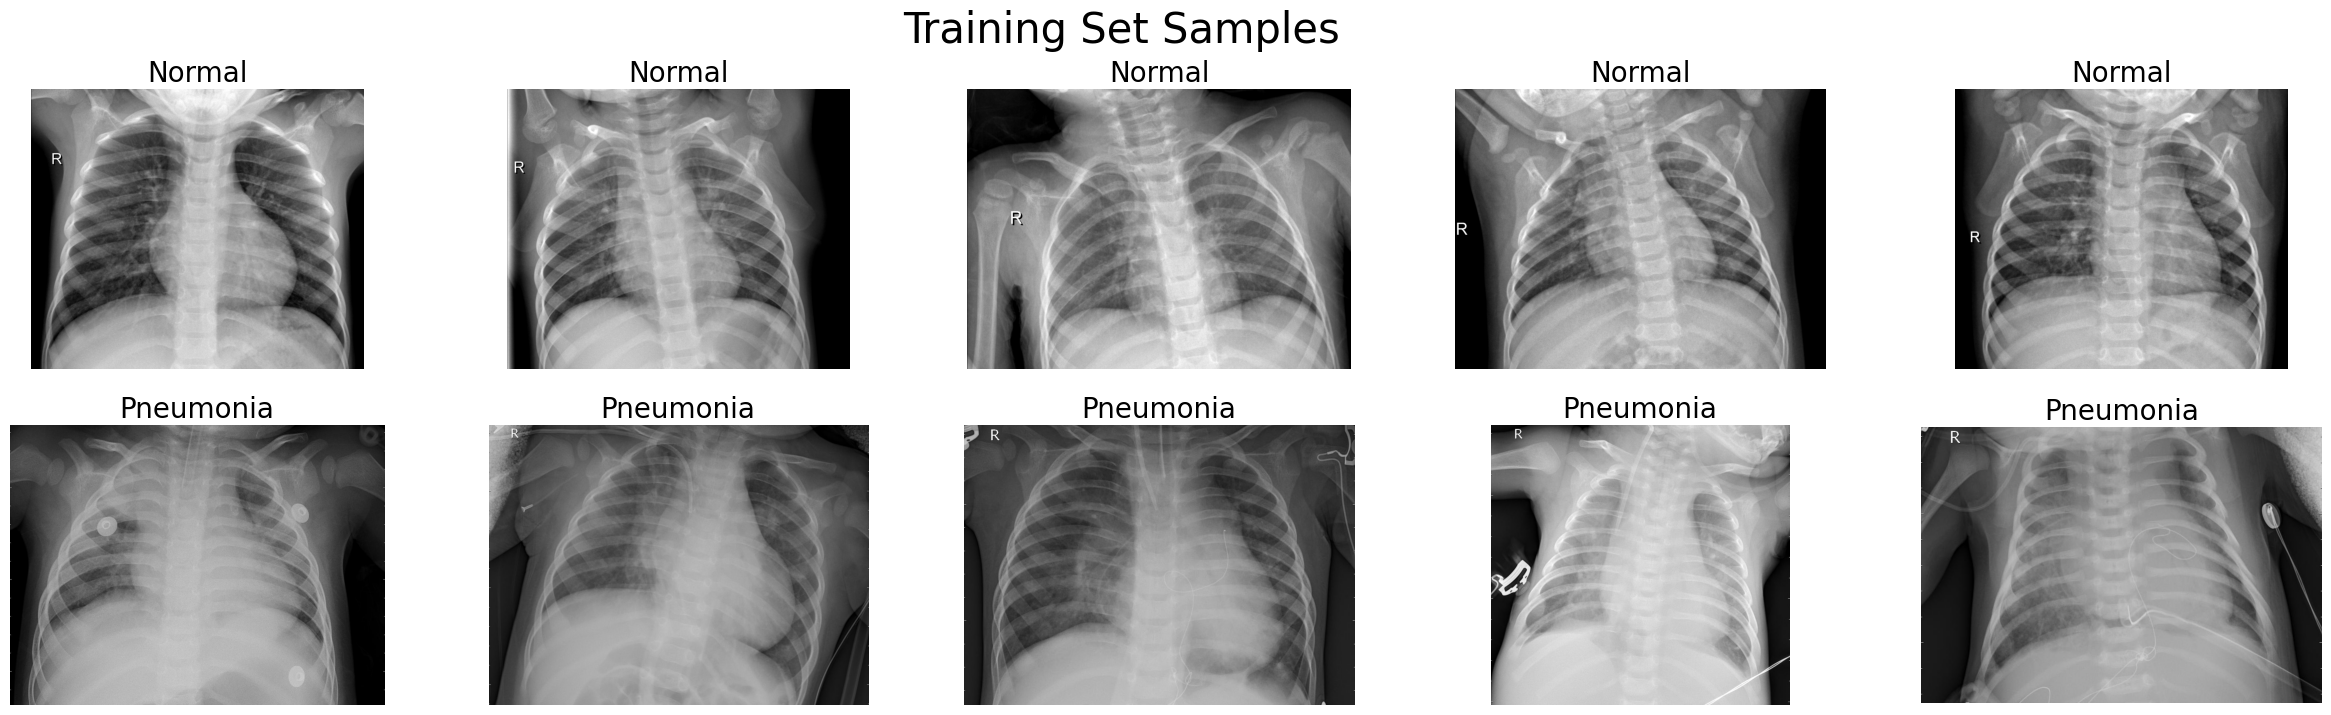

In [6]:
rand_samples = random.sample([os.path.join(path+'/train/NORMAL', filename) 
                              for filename in os.listdir(path+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(path+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(path+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

In [7]:
# set random seed so we get the same sampling every time for reproducibility

random_seed = 2020
torch.manual_seed(random_seed)
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)
len(train_ds), len(val_ds)

(5425, 2325)

In [8]:
batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

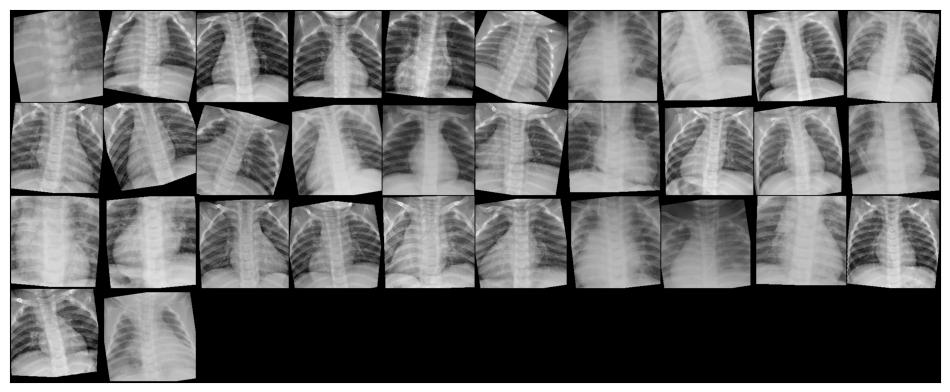

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [11]:
from transformers import AutoConfig, AutoModel


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Load configuration and model
config = AutoConfig.from_pretrained(r'C:\LMS\8\project\Medical student\CQ500_data\models\\models--nickmuchi--vit-finetuned-chest-xray-pneumonia')
vit_model = AutoModel.from_pretrained(r'C:\LMS\8\project\Medical student\CQ500_data\models\\models--nickmuchi--vit-finetuned-chest-xray-pneumonia', config=config)

for param in vit_model.parameters():
    param.requires_grad = False

vit_model

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


Some weights of ViTModel were not initialized from the model checkpoint at C:\LMS\8\project\Medical student\CQ500_data\models\\models--nickmuchi--vit-finetuned-chest-xray-pneumonia and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [12]:
# Modify the custom model to work with ViT
class ModifiedViTModel(nn.Module):
    def __init__(self, vit_model):
        super(ModifiedViTModel, self).__init__()
        self.vit_model = vit_model
        self.classifier = nn.Linear(768, 2)  # Assuming 768 is the embedding size

    def forward(self, x):
        vit_outputs = self.vit_model(x)  # this gives you ViTModelOutput
        # Extract the appropriate tensor. Assuming pooler_output is what you want:
        x = vit_outputs.pooler_output
        x = self.classifier(x)
        return x

model = ModifiedViTModel(vit_model).to(device)

In [13]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}


In [21]:
def train(model,loaders,criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model  

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [25]:
model.to(device)
epochs = 10
train(model, loaders, criterion, optimizer, scheduler,epochs)  


: 

: 